In [1]:
import torch.nn as nn
import torch
from retail import retail
import torch.distributions as d
import torch.nn.functional as F
import numpy as np
import seaborn as sns

We define the arguments used by our store. We also define the intra-day distribution as being sampled by a uniform distribution.

In [2]:
# Define main store arguments as well as sampler size
n_customers = 2500
n_buckets = 4
monte_carlo_size = 100
store_args= {'assortment_size': 1000, 'bucket_cov': torch.eye(n_buckets)/100, 'seed' : 1066,
             'max_stock': 1000, 'forecastVariance' :0., 'horizon': 100, 'lead_time': 1}
bucketDist = d.uniform.Uniform(0,1)

In [3]:
#Create the list of the average daily reward for each customer distribution for the chosen policy
summed_rewards_policy = []
for i in range(monte_carlo_size):
    sub_rewards = []
    done = False
    #Generate the store and its customer repartition throughout the day
    torch.manual_seed(i)
    sampled = bucketDist.sample((n_buckets,))
    sample_bucket_customers = (n_customers*sampled/sampled.sum()).round()
    store = retail.StoreEnv(**store_args, bucket_customers = sample_bucket_customers)
    while not (done):
        #Compute the order according to the policy 
        customers = sample_bucket_customers.max()
        p = store.forecast.squeeze()
        std = torch.sqrt(customers*p+(1-p))
        order = F.relu(3*std+store.forecast.squeeze()*customers-store.get_full_inventory_position()).round()
        # Step the environment and get its observation
        obs = store.step(order.numpy())
        # Store reward for the specific time step
        sub_rewards.append(obs[1])
        done = obs[2]
    #Append average reward of this customer repartition to the list of rewards
    summed_rewards_policy.append(torch.stack(sub_rewards).mean())

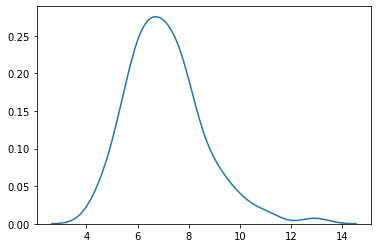

In [4]:
sns.kdeplot(torch.stack(summed_rewards_policy).numpy())

We observe a skewed distribution, where one distribution yields very high results. 

Let's investigate this distribution - it corresponds to seed 49.

In [5]:
torch.manual_seed(49)
sampled = bucketDist.sample((n_buckets,))
sample_bucket_customers = (n_customers*sampled/sampled.sum()).round()


sample_bucket_customers

tensor([  78.,  462.,  414., 1546.])

All customers are coming at the end of the day. This is actually a realistic distribution, as patrons usually visit the store after their working hours. 

In [40]:
np.savetxt("imbalance_result.csv", torch.stack(summed_rewards_policy).numpy(), delimiter=",")
